In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print(tf.__version__)

from scipy.stats import pearsonr, spearmanr
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 20,
})

2.4.0-rc0


In [3]:
diagsN7m5 = pd.read_csv('../../../data/tobias/EC3_data/diagsN7m5.csv',names=np.arange(10000)).T
fidelsN7m5 = pd.read_csv('../../../data/tobias/EC3_data/fidelsN7m5.csv',names=np.arange(10000)).T

N_instance, N_state = diagsN7m5.shape

diagsN7m5 = (diagsN7m5 - diagsN7m5.to_numpy().min())
diagsN7m5 /= (diagsN7m5.to_numpy().max() - diagsN7m5.to_numpy().min())

In [4]:
#convert fidelities into one_hot representation

In [5]:
uni_fidels = np.sort(fidelsN7m5[0].unique())

In [6]:
one_hot_fidels = pd.DataFrame()

In [7]:
for uni_fidel in uni_fidels:
    one_hot_fidels[uni_fidel] = 1*(fidelsN7m5 == uni_fidel).to_numpy().flatten()

In [8]:
one_hot_fidels

,0.405344,0.446338,0.504930,0.529460,0.542748,0.579066,0.596918,0.601784,0.617170,0.620147,...,0.656487,0.662125,0.665196,0.694049,0.696092,0.717018,0.761217,0.765388,0.774484,0.801876
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9998,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#add state number as second channel, ordered by energy, normalized to (0,1)

In [10]:
diags_CNN = diagsN7m5.to_numpy().reshape((-1,N_state,1))
state_CNN = np.linspace(0,1,N_state).repeat(N_instance).reshape(N_state,N_instance).T.reshape((-1,N_state,1))

diags_CNN_twoChannel = np.append(diags_CNN,state_CNN,axis=2)


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(diags_CNN_twoChannel, \
                                                     one_hot_fidels,\
                                                     test_size=.2)



In [12]:
remaining = 1

X_train_reduced = np.zeros((X_train.shape[0],N_state*remaining,2))
choice = np.arange(N_state)>=N_state*(1-remaining)
for i in range(X_train.shape[0]):
    np.random.shuffle(choice)
    X_train_reduced[i,:] = X_train[i,choice]

X_test_reduced = np.zeros((X_test.shape[0],N_state*remaining,2))
choice = np.arange(N_state)>=N_state*(1-remaining)
for i in range(X_test.shape[0]):
    np.random.shuffle(choice)
    X_test_reduced[i,:] = X_test[i,choice]

In [13]:
#CNN

In [14]:
tf.keras.backend.clear_session()
model = keras.Sequential(name='CNN_classifier')
model.add(layers.Conv1D(8, (3,), activation='relu', padding='same', input_shape=(N_state*remaining, 2)))
model.add(layers.Conv1D(16, (3,), activation='relu', padding='same'))
model.add(layers.Conv1D(32, (3,), activation='relu', padding='same'))
model.add(layers.AveragePooling1D((16,)))
model.add(layers.Flatten())
model.add(layers.Dropout(.0))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(fidelsN7m5.nunique(axis=0)[0], activation=tf.keras.activations.softmax))



In [15]:
model.compile(loss='CategoricalCrossentropy',optimizer=tf.keras.optimizers.Adam(.002),metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
hist = model.fit(X_train_reduced, Y_train, \
             epochs=2000,verbose=0,\
             validation_split=.2,batch_size=128,\
             callbacks=[stop_early])

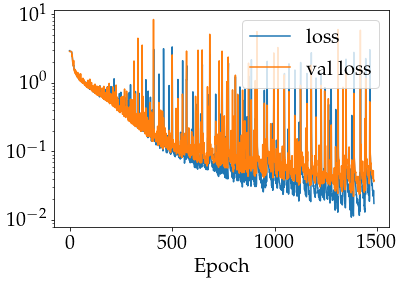

In [16]:
plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.legend()

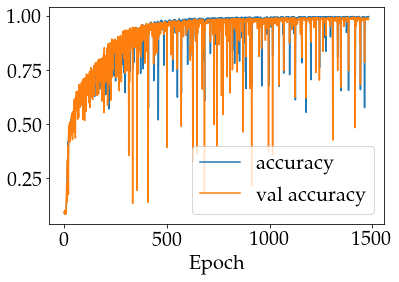

In [17]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.legend()

In [18]:
#apply trained CNN to test data

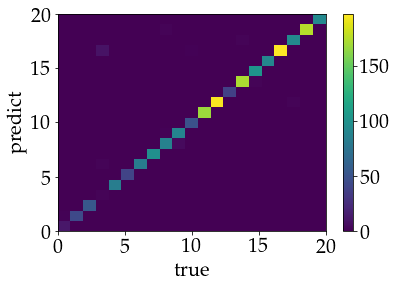

In [44]:
plt.hist2d(Y_test.to_numpy().argmax(axis=1),model.predict(X_test_reduced).argmax(axis=1),bins=21);
plt.xlabel('true')
plt.ylabel('predict')
plt.colorbar()

In [77]:
import common_functions

In [80]:
import common_functions

In [71]:
common_functions.

AttributeError: module 'common_functions' has no attribute 'test'

In [67]:
common_functions.model_HP(0)

NameError: name 'tf' is not defined